In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
import joblib

加载UCI HAR Dataset Inertial Signals中的数据 堆叠为三维的X矩阵和一维的y矩阵
x矩阵维度代表的是（样本数，数据点个数，传感器个数（九轴））

In [2]:
def load_dataset(path, group):

    X = []
    for root, dirs, files in os.walk(path):
        for name in files:
            df = pd.read_csv(path+name, header=None, delim_whitespace=True)
            # print(df)
            X.append(df.values)

    X = np.dstack(X)
    return X

In [3]:
TRAIN_DIR = 'C:/Users/Joker/Desktop/SURF/UCI HAR Dataset/train'
TEST_DIR = 'C:/Users/Joker/Desktop/SURF/UCI HAR Dataset/test'
DATA_DIR = '/Inertial Signals/'
train_X = load_dataset(TRAIN_DIR+DATA_DIR, 'train')
test_X = load_dataset(TEST_DIR+DATA_DIR, 'test')
train_y = pd.read_csv(TRAIN_DIR+'/y_train.txt').values
test_y = pd.read_csv(TEST_DIR+'/y_test.txt').values

print('{}.shape:{},{}.shape:{}\n'.format(
    'train_X', train_X.shape, 'train_y', train_y.shape))
print('{}.shape:{},{}.shape:{}\n'.format(
    'test_X', test_X.shape, 'test_y', test_y.shape))

train_X.shape:(7352, 128, 9),train_y.shape:(7351, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2946, 1)



统计各活动的分布频率，包括训练集，测试集和总集

In [4]:
def class_distribution_statistics(y):

    df = pd.DataFrame(y)
    counts = df.groupby(0).size().values
    print(counts)

    plt.pie(counts, labels=['WALKING', 'WALKING_UPSTAIRS',
            'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], autopct='%.2f%%')

Train Dataset Class Distribution
[1226 1073  986 1286 1373 1407]


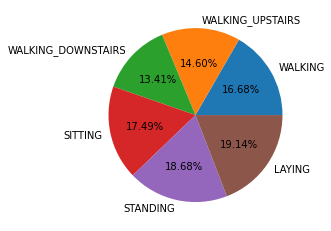

In [5]:
print('Train Dataset Class Distribution')
class_distribution_statistics(train_y)

Test Dataset Class Distribution
[496 471 420 491 531 537]


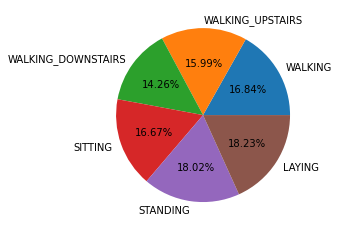

In [6]:
print('Test Dataset Class Distribution')
class_distribution_statistics(test_y)

Total Class Distribution
[1722 1544 1406 1777 1904 1944]


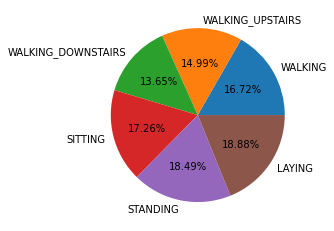

In [7]:
print('Total Class Distribution')
combined = np.vstack((train_y, test_y))
class_distribution_statistics(combined)

从饼状图可以看出，每个活动类的分布非常相似，每项数据频率均在13%-19%之间,分布非常平衡。由此可见，使用该数据集进行模型训练很可能是安全的。

In [8]:
def get_sub_map(subject_path):
    '''
    获取训练集或测试集中包含志愿者编号的唯一索引列表
    '''
    sub_map = pd.read_csv(subject_path).values
    # 找到训练集中包含哪些志愿者（返回唯一索引列表）的数据（数据集由30位志愿者收集）
    subjects_list = np.unique(sub_map)
    return sub_map, subjects_list

In [9]:
def data_for_subject(X, y, sub_map, sub_id):
    '''
    根据志愿者编号来从数据X和标签y中截取相应的行数据
    '''
    ix = [i for i in range(len(sub_map)) if sub_map[i] == sub_id]
    # print(ix)
    return X[ix, :, :], y[ix]

In [10]:
SUBJECT_TRAIN_PATH = 'C:/Users/Joker/Desktop/SURF/UCI HAR Dataset/train/subject_train.txt'
train_sub_map, train_subjects_list = get_sub_map(SUBJECT_TRAIN_PATH)
print(train_subjects_list)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [11]:
subject_id=train_subjects_list[0]
subject_X, subject_y = data_for_subject(
    train_X, train_y, train_sub_map, subject_id)

print('subject_X.shape:{}\nsubject_y.shape:{}'.format(
    subject_X.shape, subject_y.shape))

subject_X.shape:(346, 128, 9)
subject_y.shape:(346, 1)


In [12]:
def to_series(windows):
    '''
    将窗口序列数据转换为列表
    '''
    series = list()

    for window in windows:
        # 消除重叠窗口部分
        half = int(len(window) / 2) - 1  # 窗口一半的宽度；原数据重叠率为50%
        # 切片截取每一行的后半部分数据，正好避开重叠部分（上一行的后半部分和下一行的前半部分是重叠的）
        for value in window[-half:]:
            series.append(value)
    return series

In [13]:
def subject_plotter(subject_id):
    '''
    根据志愿者标号绘制其9轴传感器数据和活动变化图
    '''

    off = 0
    name_list = ['total acc ', 'body acc ', 'body gyro ']
    axis_list = ['x', 'y', 'z']

    for name in name_list:
        for i, axis in enumerate(axis_list, start=0):
            # 创建n行1列的画布，在off+1位置绘图；
            fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
            # X[:,:,off] 三维数组切片中，off通过for循环实现递增，
            # 一次截取一个特征的所有数据（二维数组），输入到to_series函数进行处理，实现去除重叠部分。
            ax.plot(to_series(subject_X[:, :, off]))
            ax.set_title(name + axis, y=0, loc='left', size=18)
            ax.set_ylabel(r'$Value$', size=16)
            ax.set_xlabel(r'$timesteps$', size=16)
            off += 1

    fig, ax = plt.subplots(figsize=(12, 4), dpi=150)
    ax.plot(subject_y)
    ax.set_title('activity', y=0, loc='left', size=18)
    ax.set_ylabel(r'$Class$', size=16)
    ax.set_xlabel(r'$Nums$', size=16)
    plt.tight_layout()

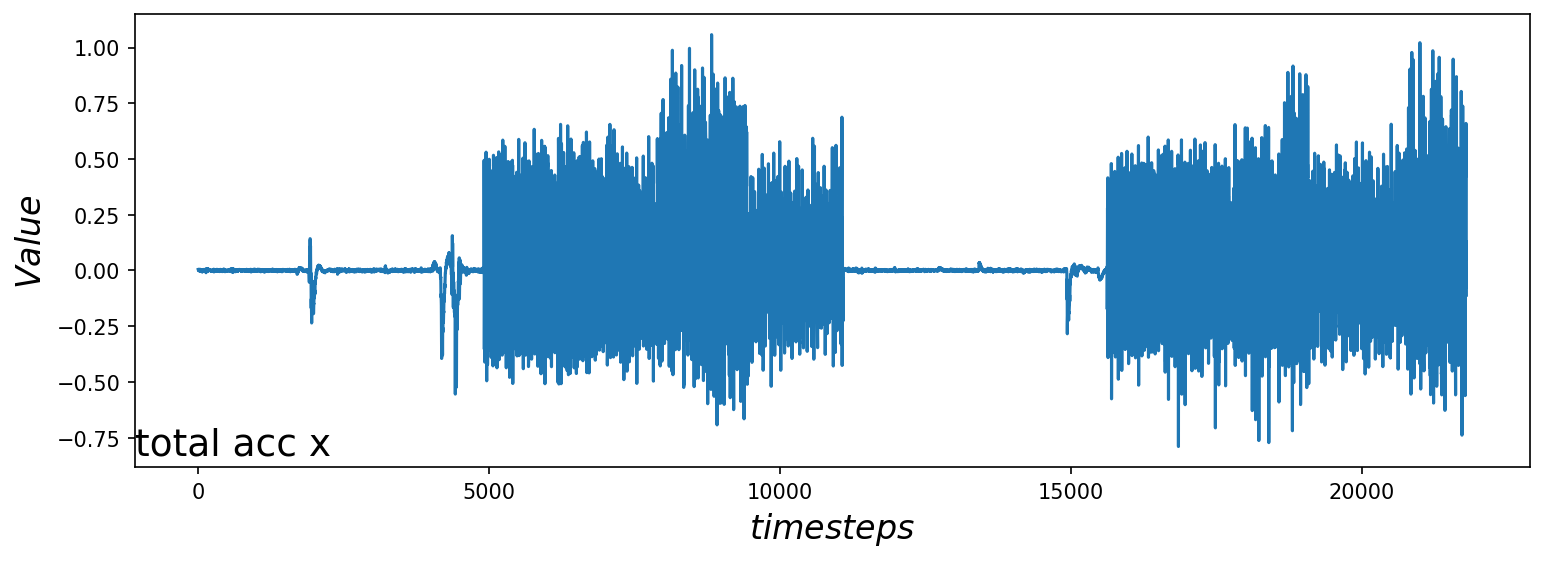

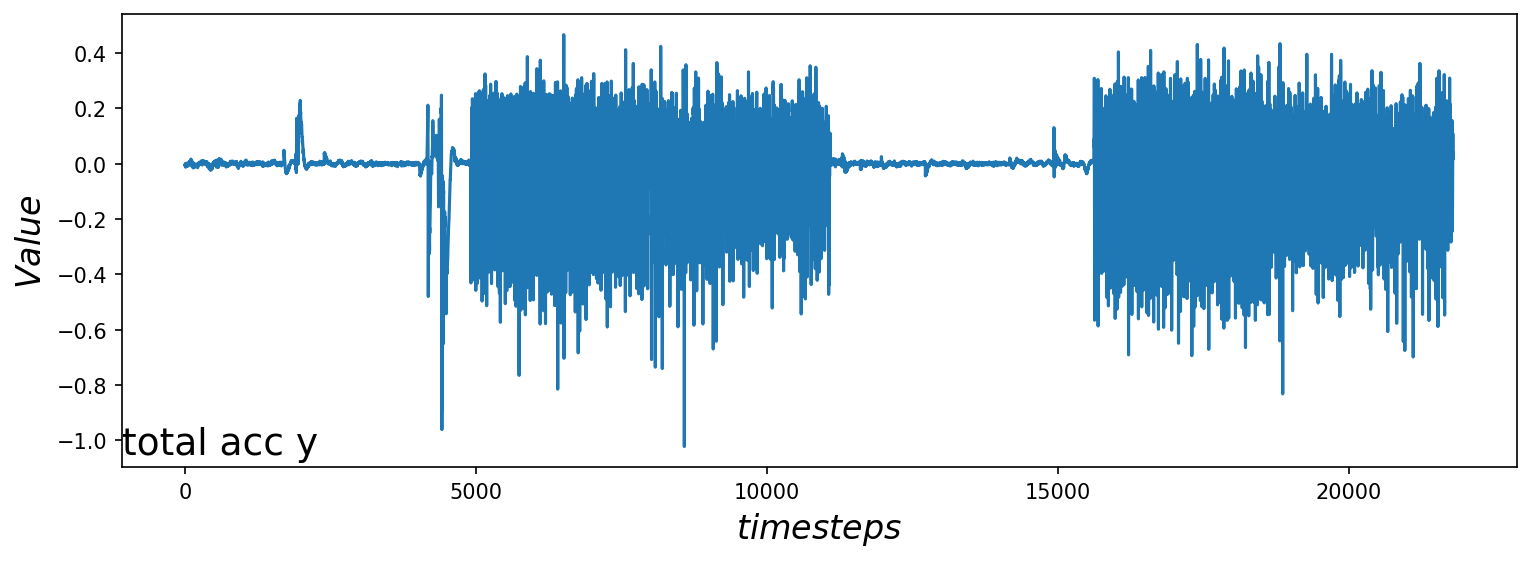

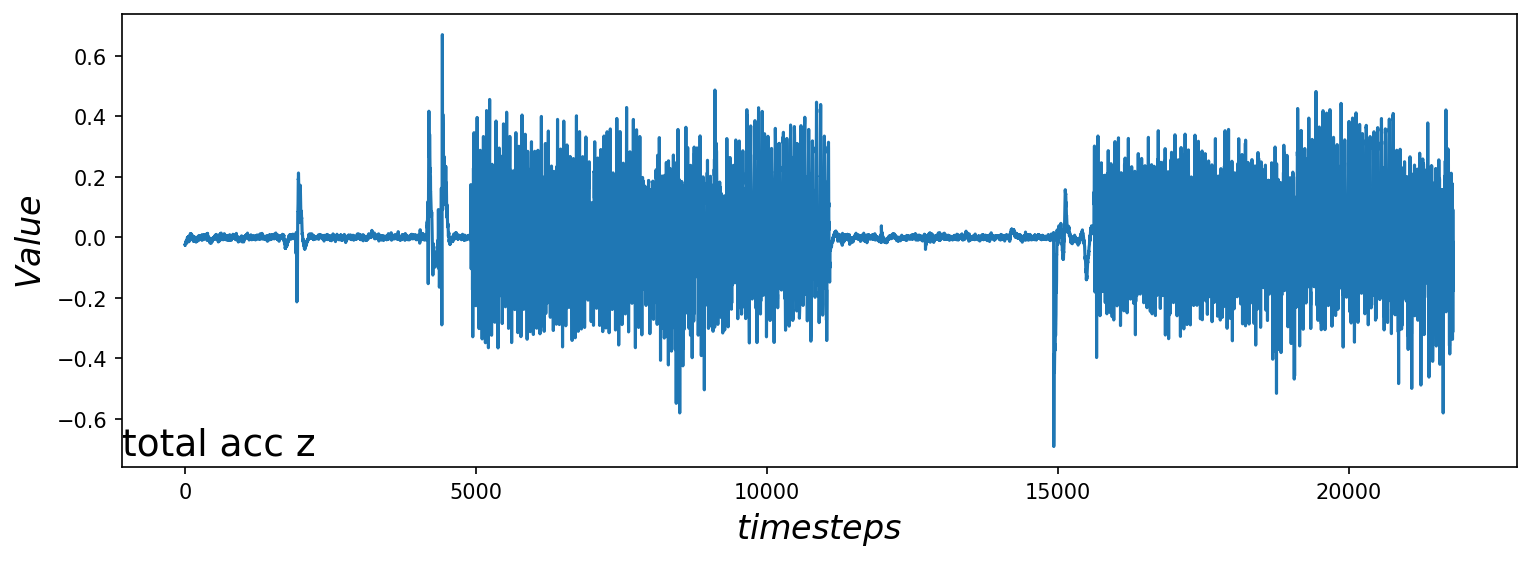

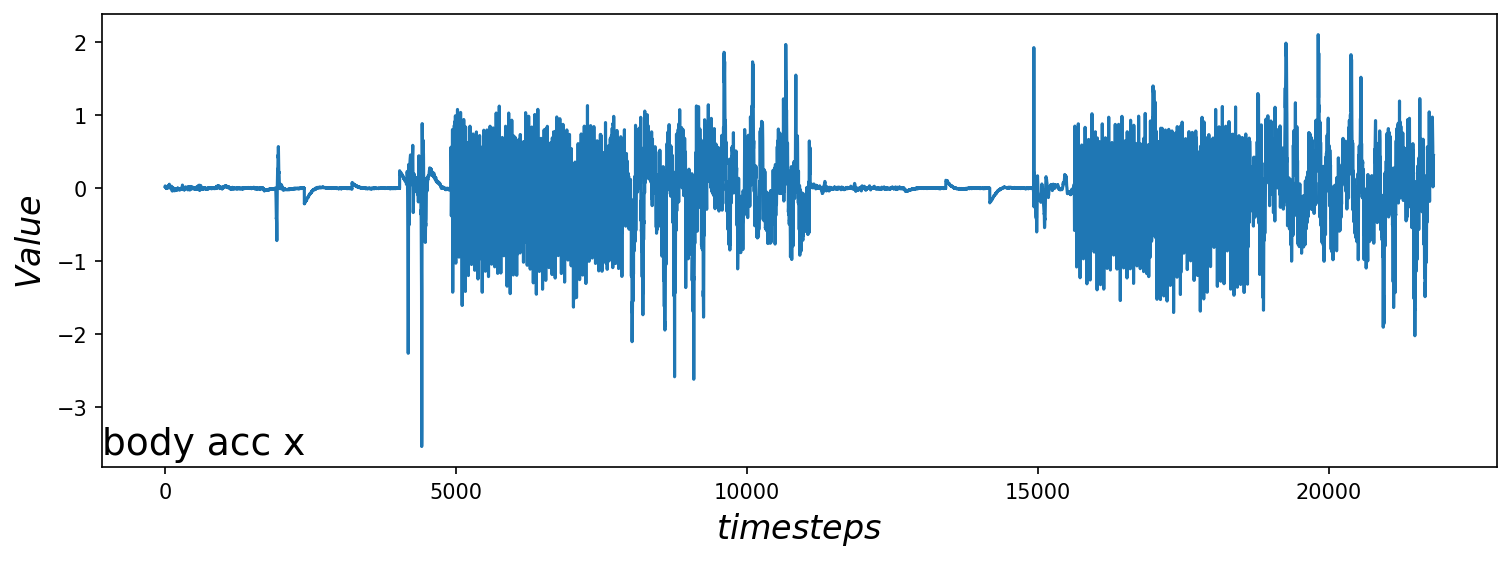

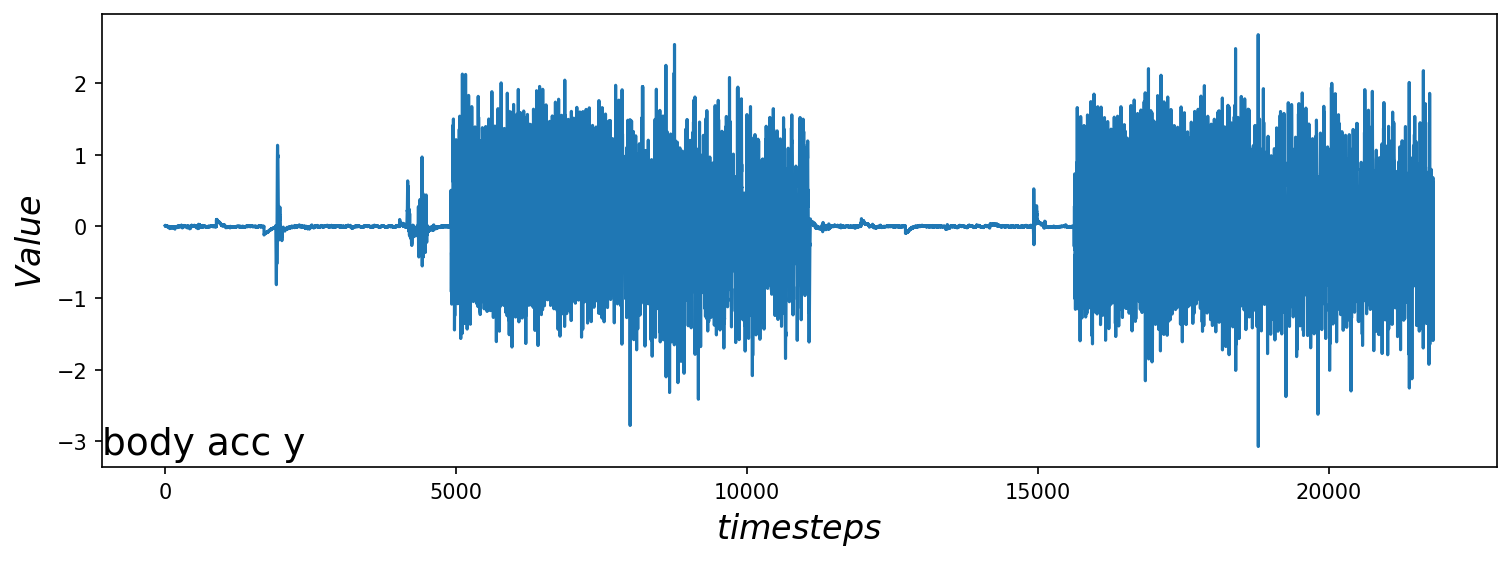

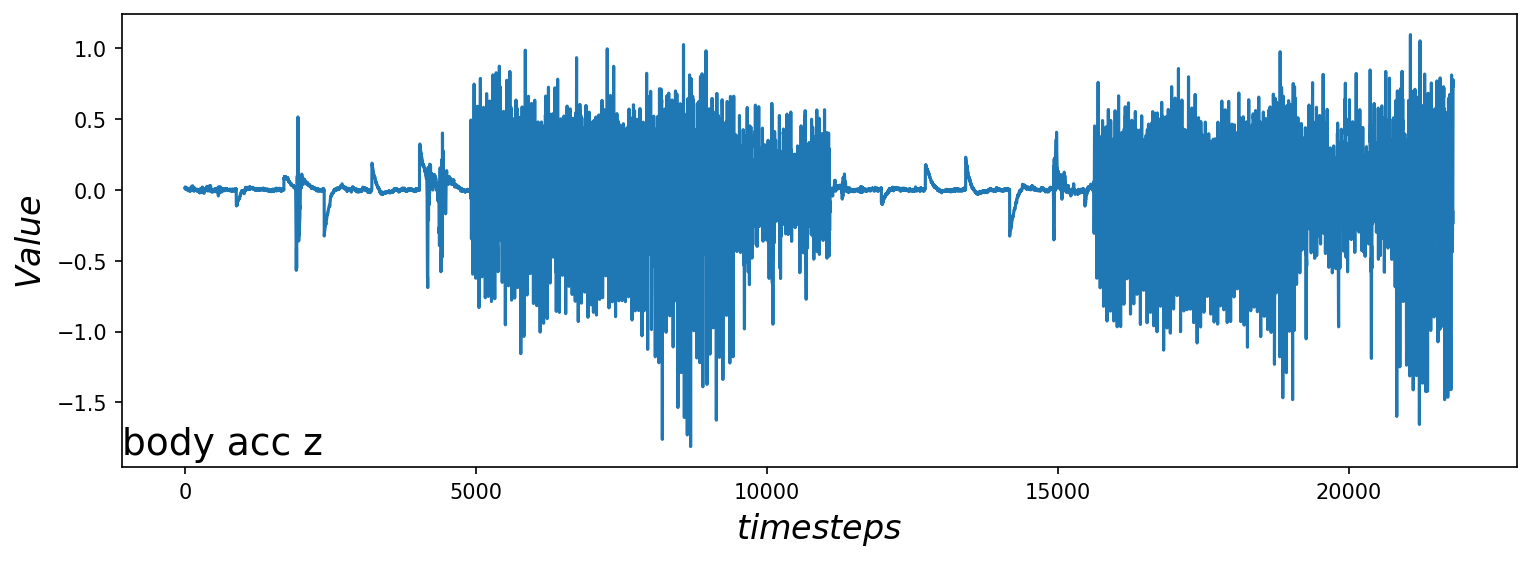

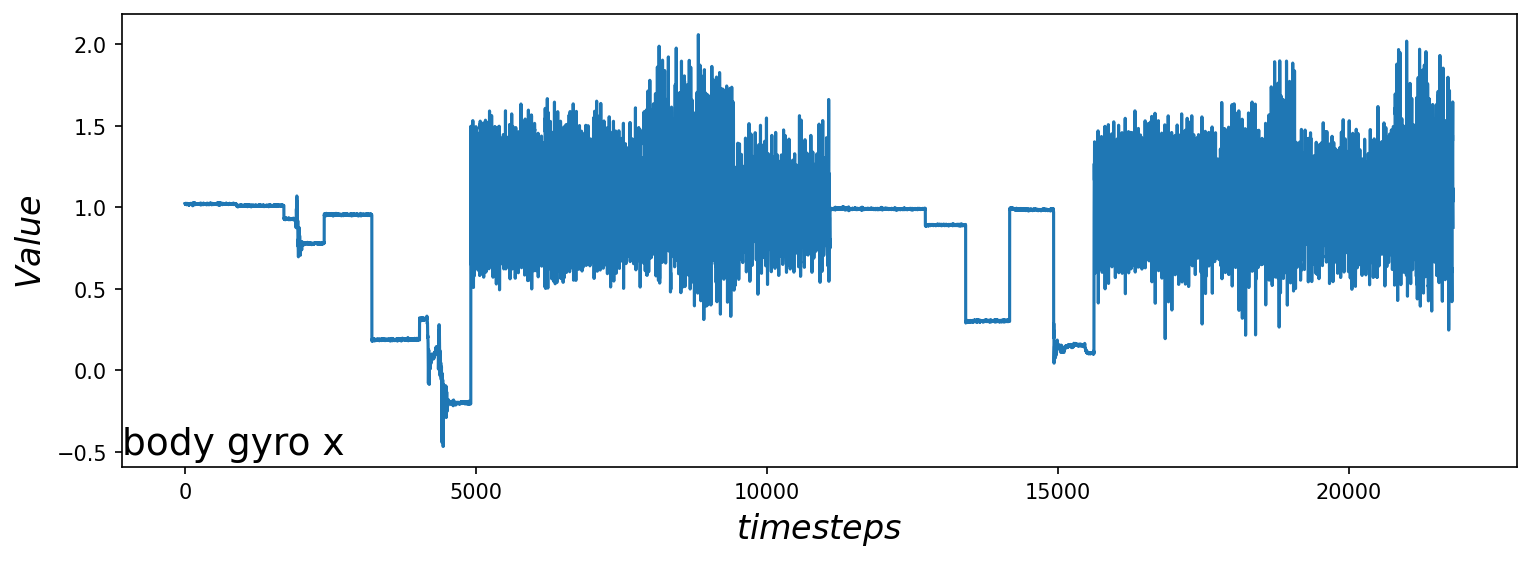

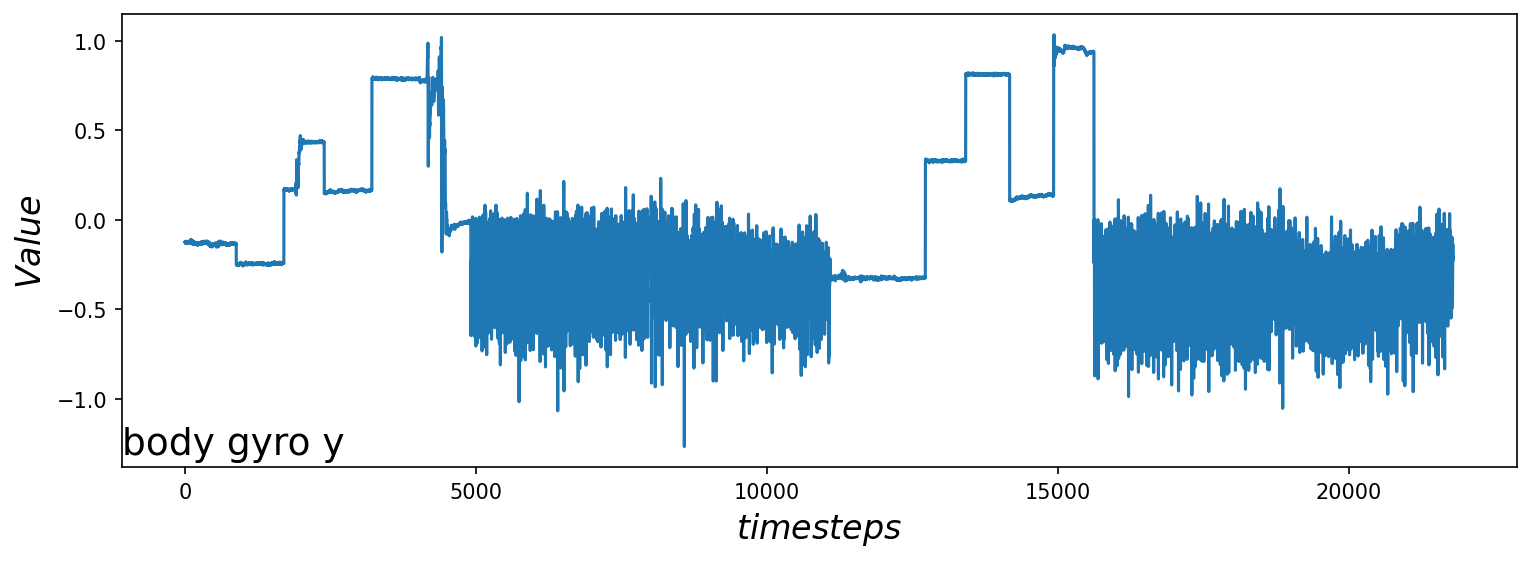

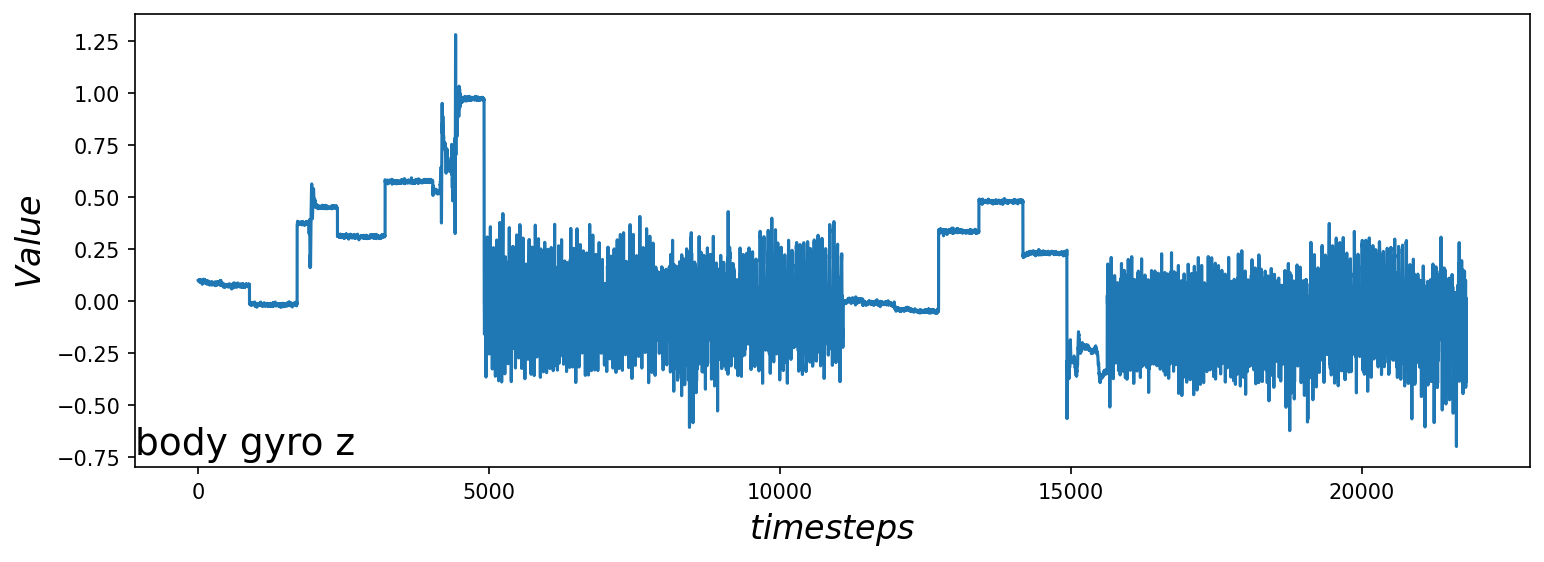

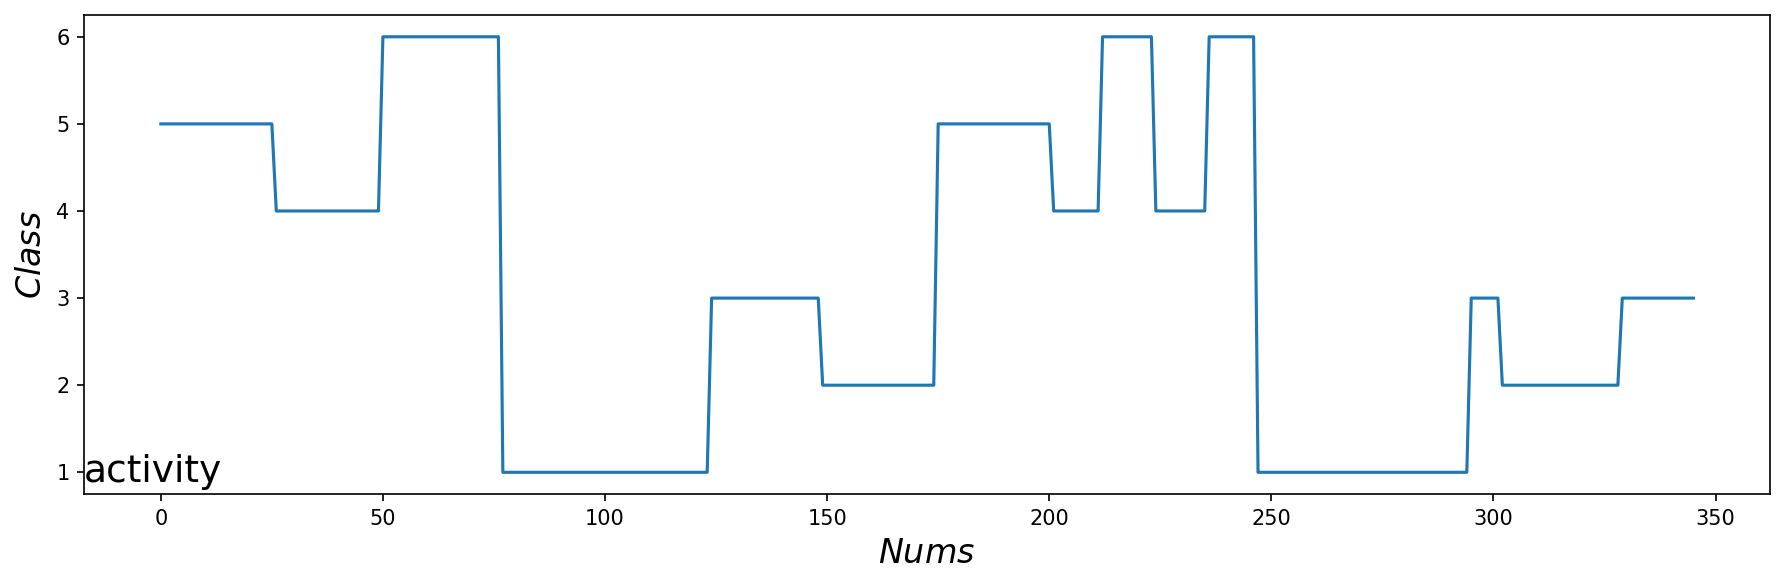

In [14]:
subject_plotter(subject_id) #绘制列表中第一个志愿者（id为1）的加速度数据

1：Walking  
2：Walking-upstairs  
3：Walking-downstairs  
4：Sitting  
5：Standing  
6：Laying  

从图中可以看出活动1、2、3（与步行活动相关）相对应的曲线比较密集，活动4、5和6（坐着，站着和躺着）的虚线相对比较平缓，基本上为直线。这很好地证实了已正确加载的数据集的解释。
这个志愿者执行了两次相同的一般活动序列（一次将手机绑在腰间，一次任意放置。），并且某些活动执行了两次以上。因此对给定的志愿者，不应假设哪些活动已经被执行或者其顺序。
一些固定活动（例如躺下）的曲线的波动相对较大，可能与异常值或活动转换有关。这九个变量之间有很多共性。很可能只需要这些迹线的一个子集就可以建立预测模型。

如果要查看每一类活动的分布情况，一种简单的方式是查看指定志愿者的数据分布情况。希望看到单个志愿者的不同活动的运动数据之间的分布有所不同，可以通过为每个活动创建直方图来查看此情况，并在每个图上使用给定数据类型的三个轴。同样，这些图可以竖直，以按活动比较每个数据轴的分布。首先，将数据按活动类型分组，然后为每个活动创建一个子图，并将数据的每个轴添加到直方图。

In [15]:
# 将数据按活动类别分组
def data_by_activity(X, y, activities):
    return {a: X[y[:, 0] == a, :, :] for a in activities}

In [16]:
def activity_histograms_plotter(X, y, sensor_type_id):

    activity_ids = np.unique(y[:, 0])  # 获取训练集或测试集标签中的类别编号（1-6）
    print(activity_ids)
    grouped = data_by_activity(X, y, activity_ids)
    plt.figure(figsize=(12, 20), dpi=150)

    activity_list = ['Walking', 'Walking-upstairs',
                     'Walking-downstairs', 'Sitting', 'Standing', 'Laying']

    for i, activity in enumerate(activity_list, start=0):
        act_id = activity_ids[i]

        for j in range(3):  # 总的加速度
            ax = plt.subplot(len(activity_ids), 1, i+1)
            ax.set_xlim(-1, 1)
            plt.hist(to_series(grouped[act_id]
                     [:, :, sensor_type_id + j]), bins=100)

        plt.title(activity, y=0, loc='left', size=18)
    plt.tight_layout()
    plt.show()

[1 2 3 4 5 6]


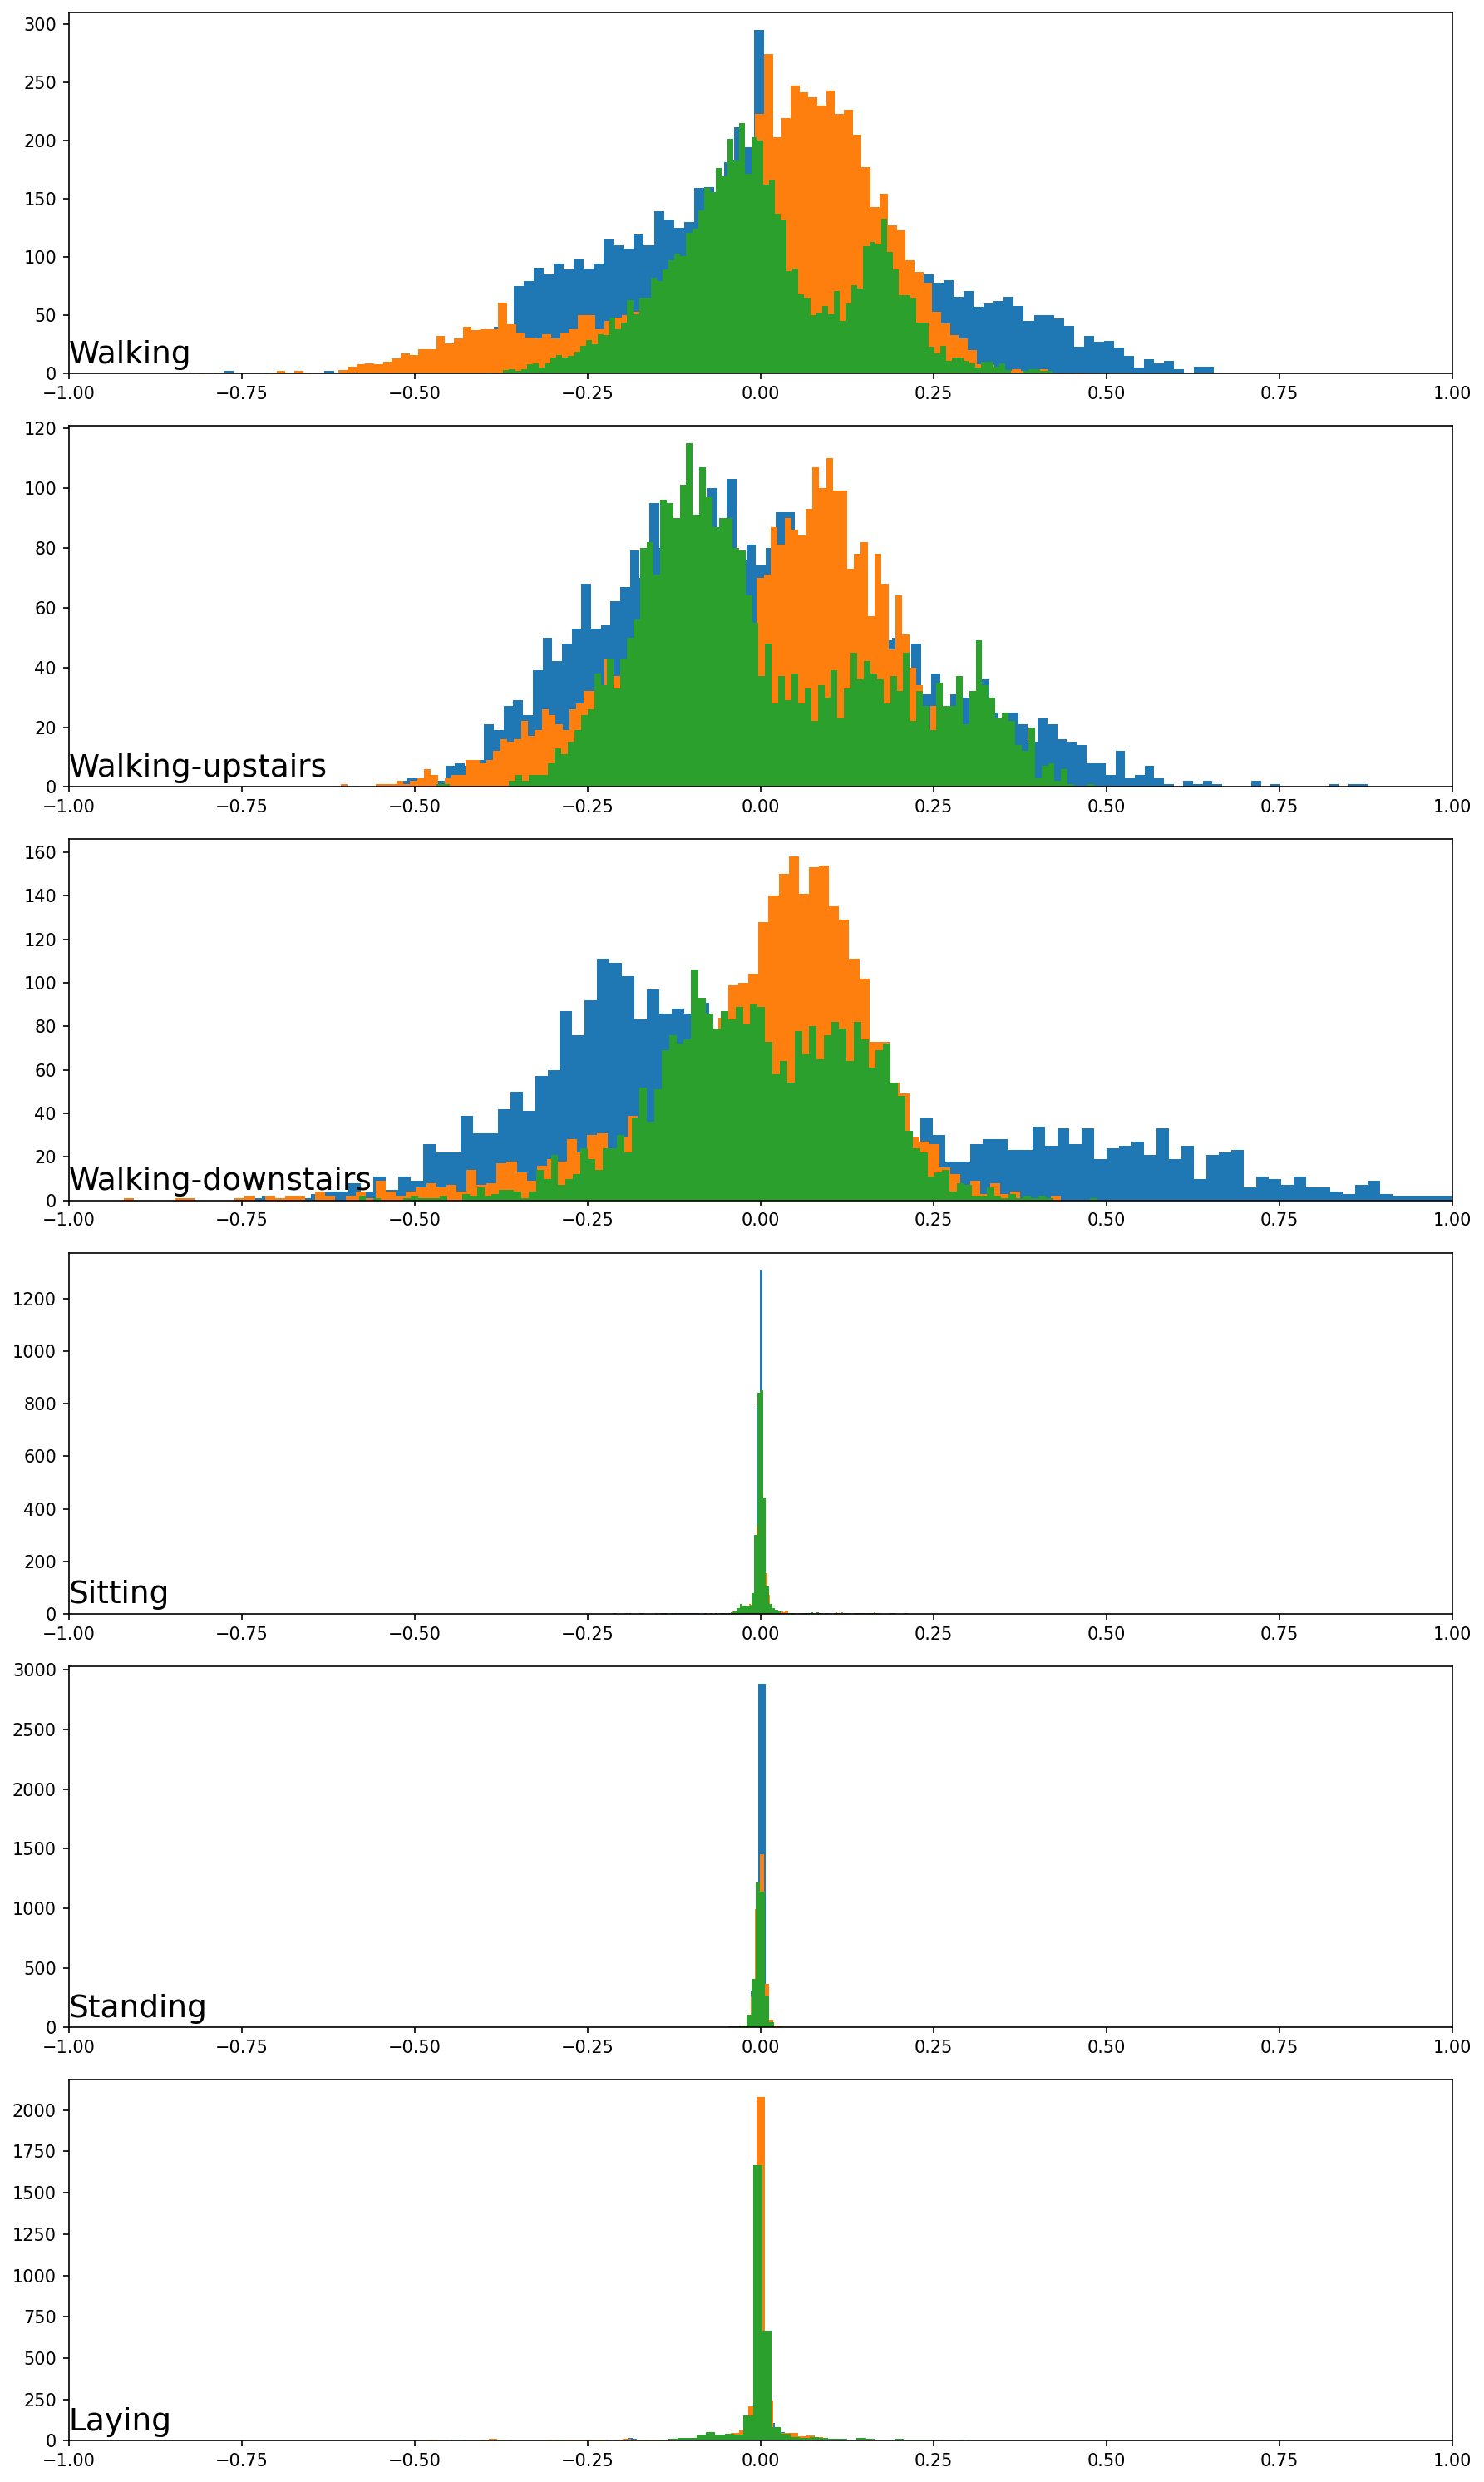

In [17]:
activity_histograms_plotter(subject_X, subject_y, sensor_type_id=0)  # 身体加速度

第一张图显示了每个活动的身体加速度分布。可以看到，运动中的活动，静止的活动之间的活动分布更为相似。在运动活动中，数据看起来是双峰的；在静止活动中，数据看起来是高斯的或指数的。活动的总加速度与身体加速度分布所看到的模式反映了在上一部分中针对相同的数据类型所看到的结果。总加速度数据也许是区分活动的关键。

[1 2 3 4 5 6]


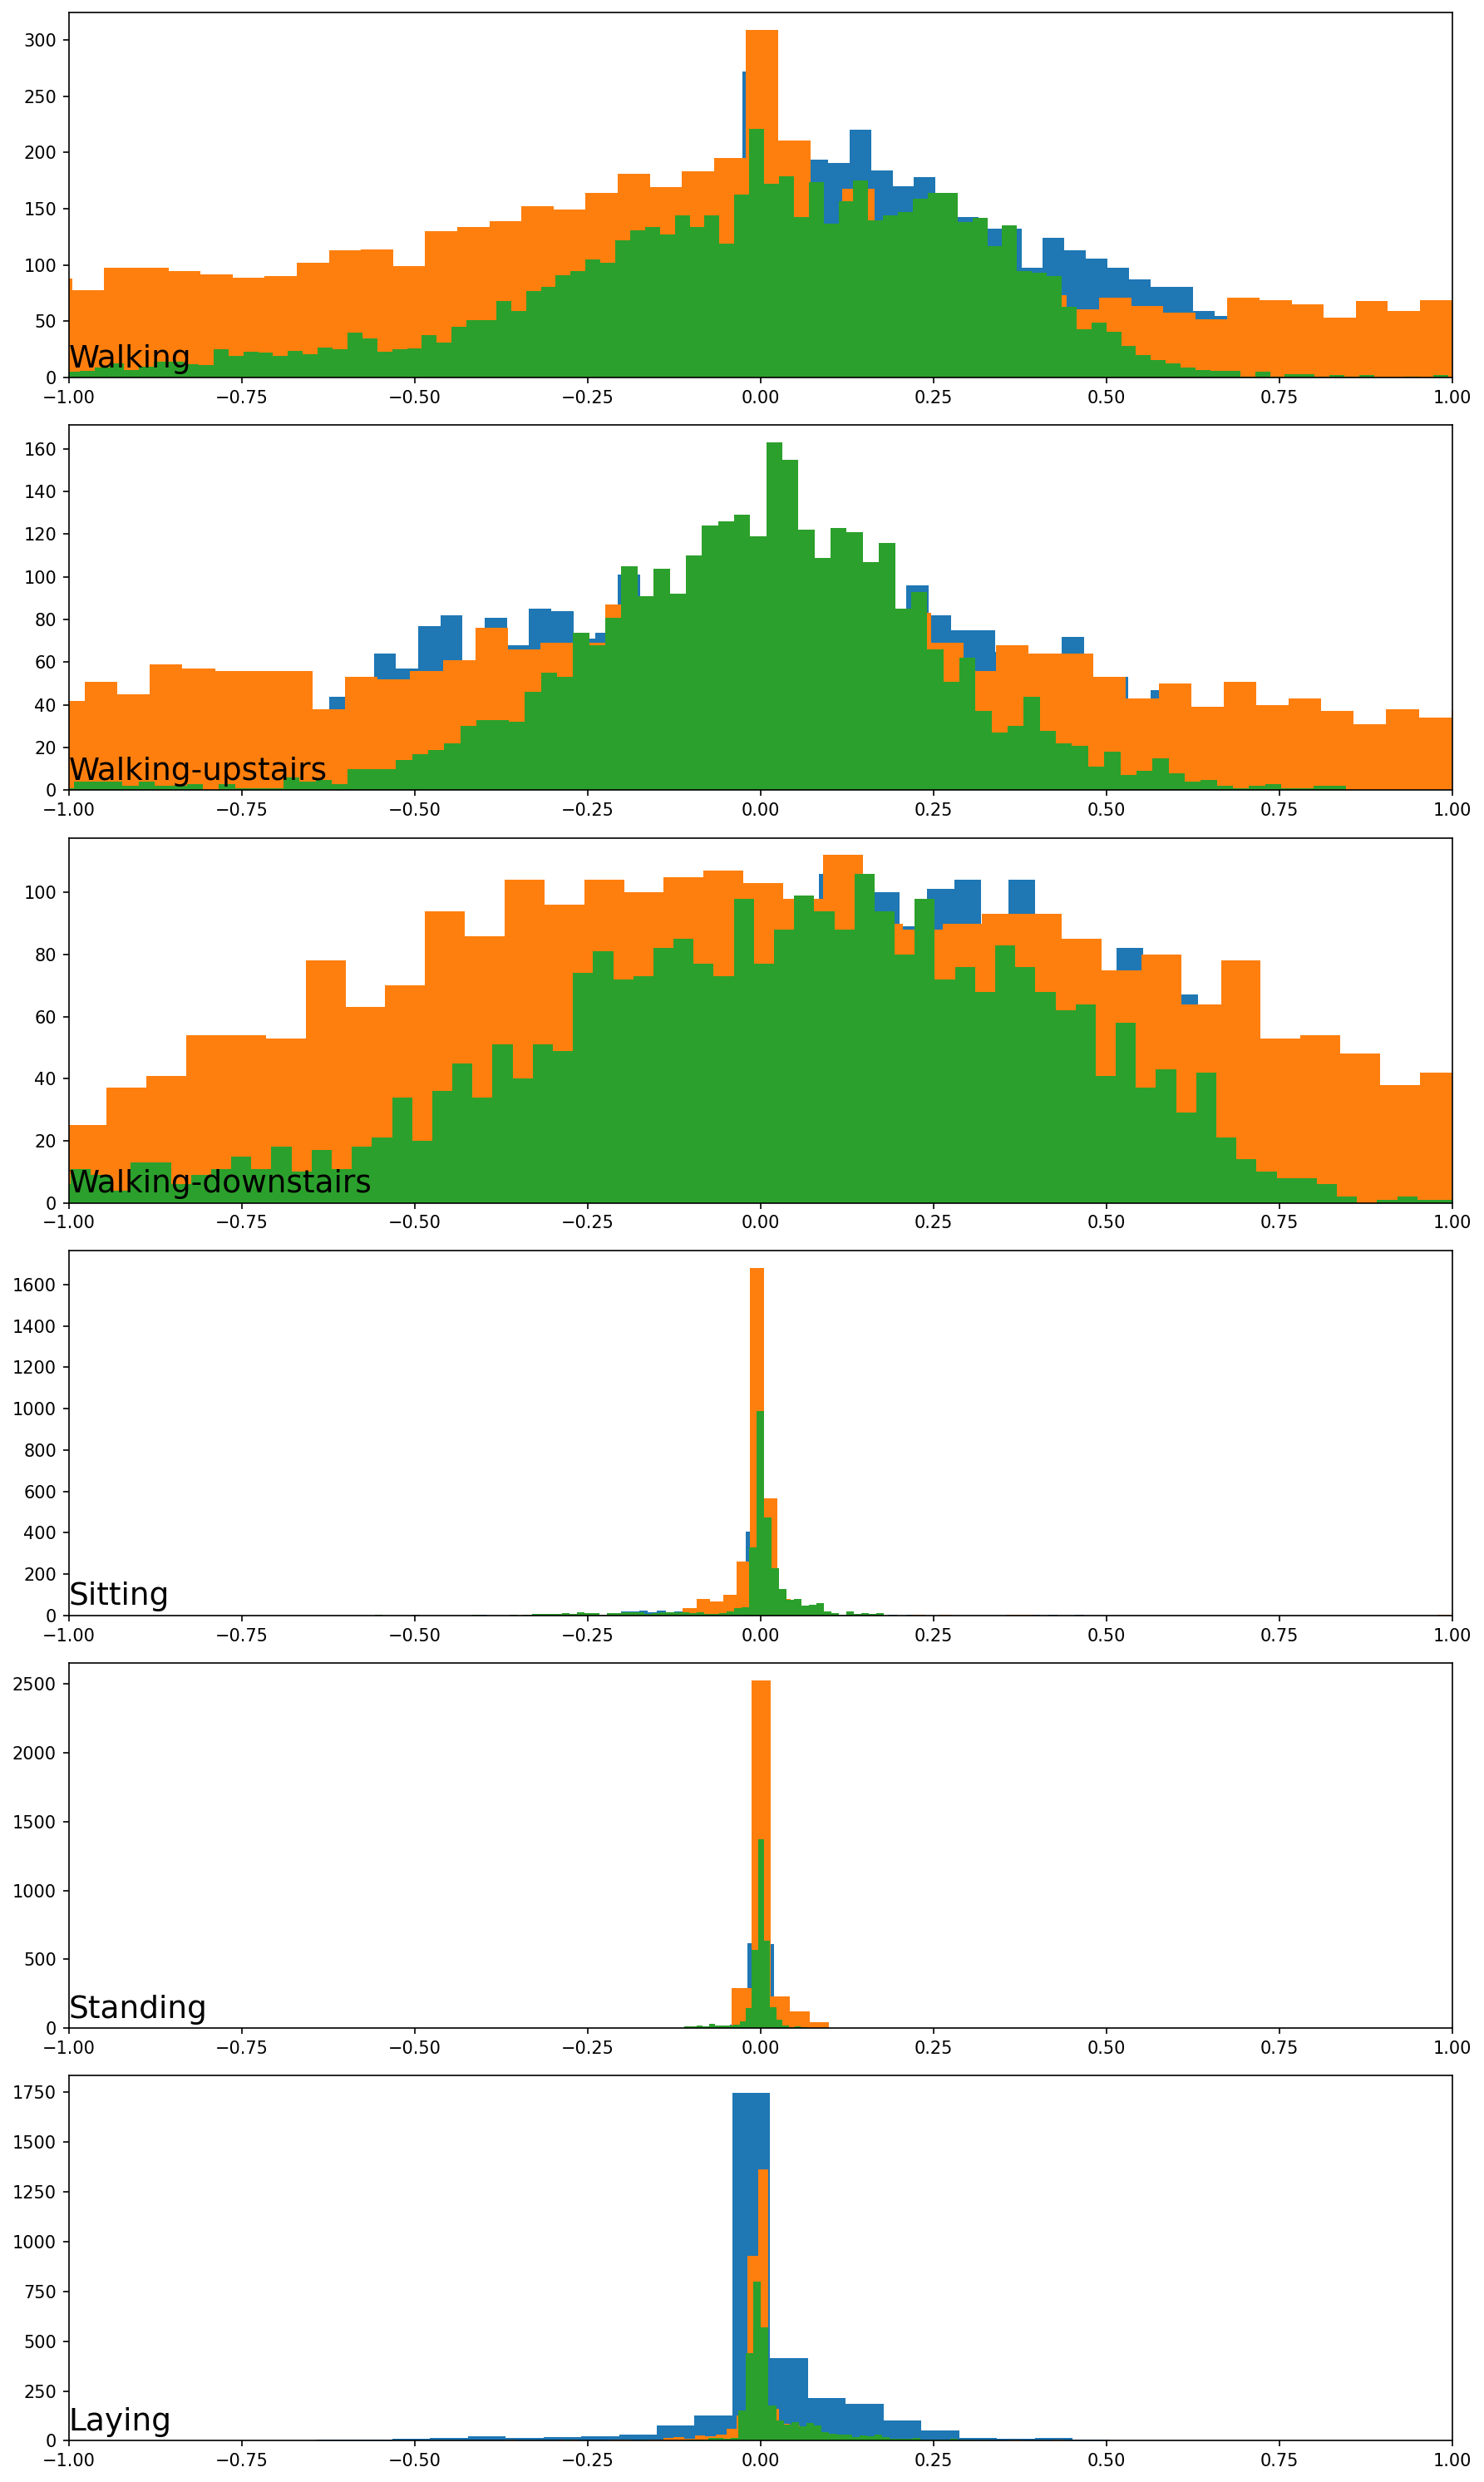

In [18]:
activity_histograms_plotter(subject_X, subject_y, sensor_type_id=3)  # 身体角速度

第二张图显示了第7位志愿者的每项活动的陀螺仪数据。

[1 2 3 4 5 6]


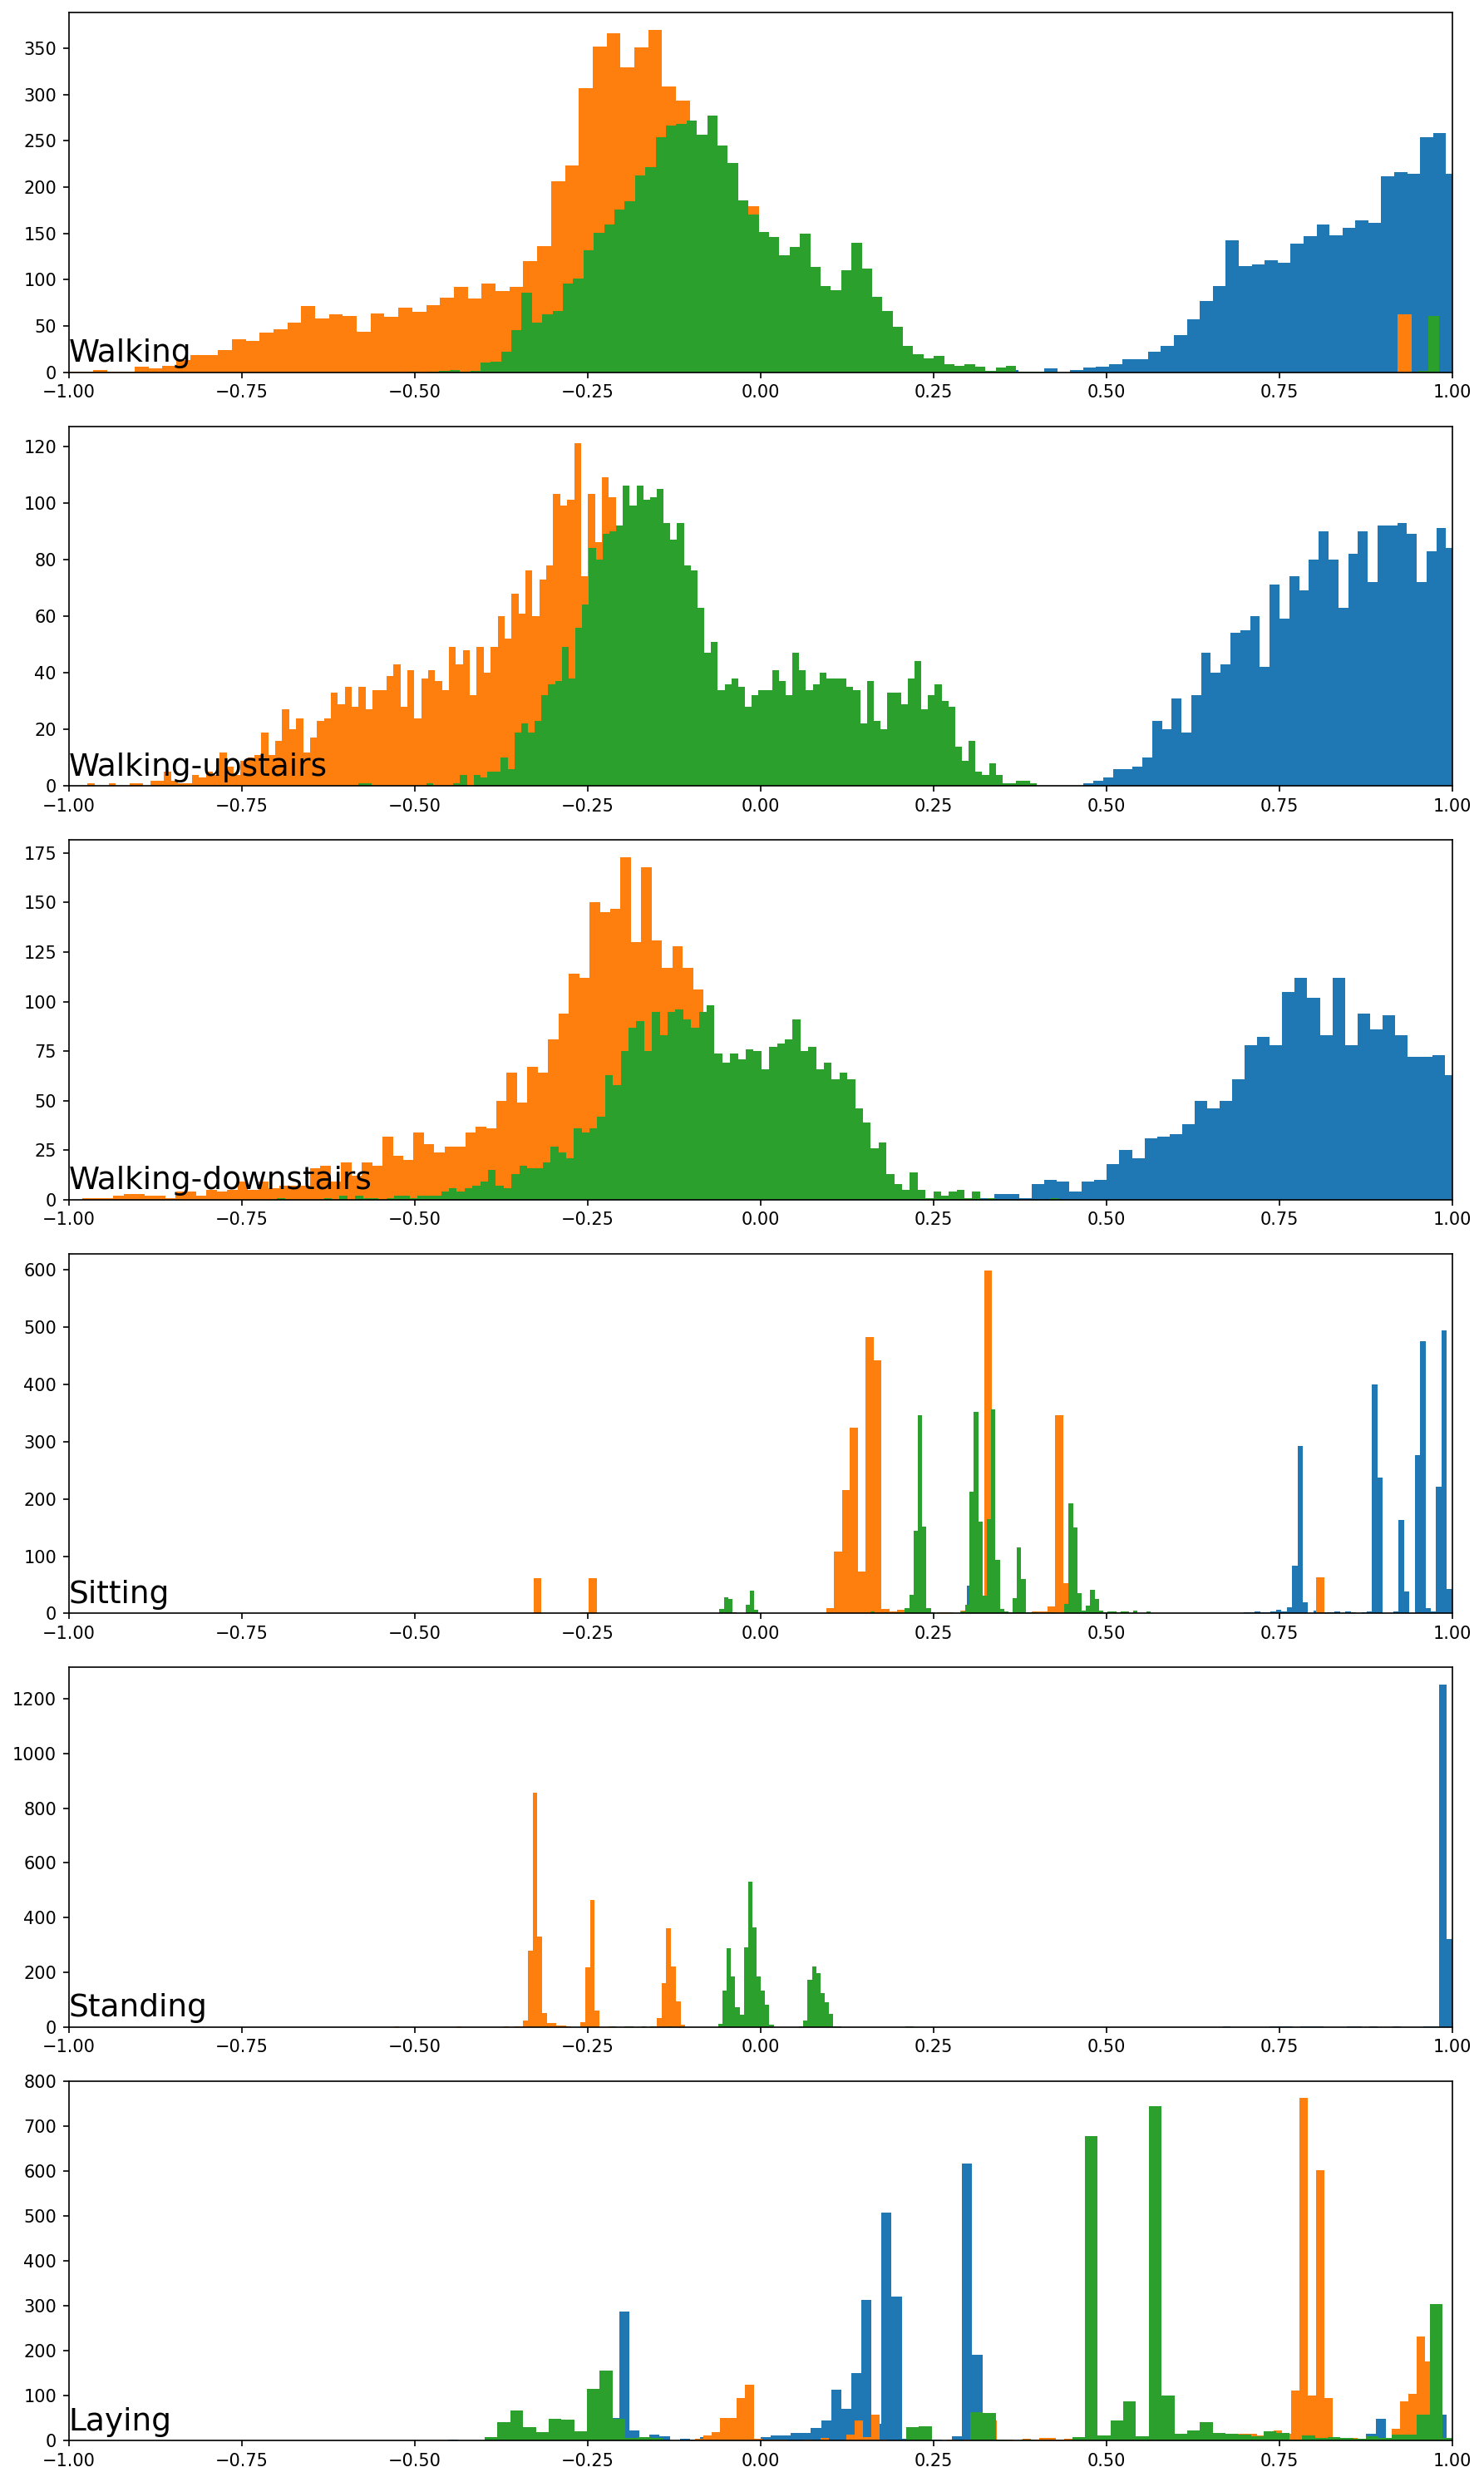

In [19]:
activity_histograms_plotter(subject_X, subject_y, sensor_type_id=6)  # 重力加速度

最后一张图中，可以看到每个活动具有不同的数据分布，运动的活动（前三个活动）与静止活动（后三个活动）之间存在明显差异。前三个活动的数据分布看起来是高斯分布，其均值和标准差可能有所不同；后一种活动的分布看起来是多峰的。

数据预处理部分

A Public Domain Dataset for Human Activity Recognition Using Smartphones使用了50hz的采样率对加速度数据进行采集



标准化
在信号噪声处理完毕后，需要对数据进行处理，使其分布在[-1,1]的区间

去除异常点

加窗
Human Activity Recognition on Smartphones using a Multiclass Hardware-Friendly Support Vector Machine
将数据分割成2.56秒的固定窗口，重叠50%。通过窗口重叠来避免活动转换导致的识别误差，同时将窗口长度设定为2.56s。
暂时考虑采用和论文一样的设定进行数据处理，通过改变窗口和重叠率来评估得出的模型准确率


滤波处理。
使用中值滤波器和一个截止频率为20hz的三阶低通滤波器对人体加速度信号进行处理 在使用一个巴特沃斯滤波器分离人体加速度和重力加速度

In [20]:
def file_loader(path):
    return pd.read_csv(path, sep='/', header=None).values

(801,)
<class 'numpy.ndarray'>


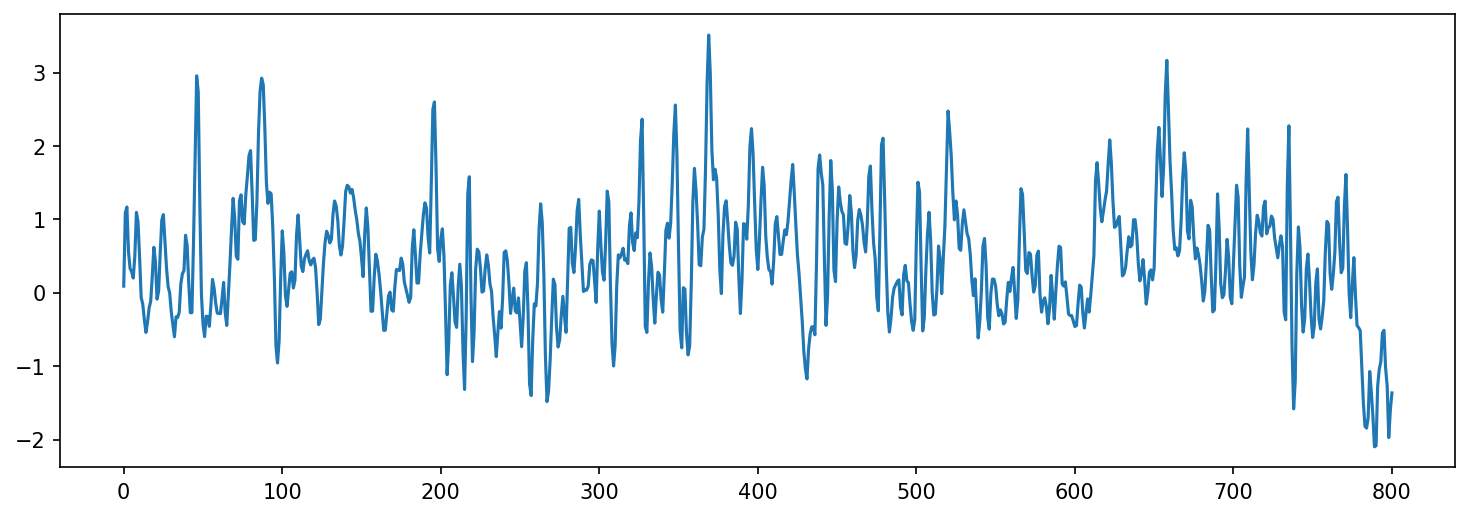

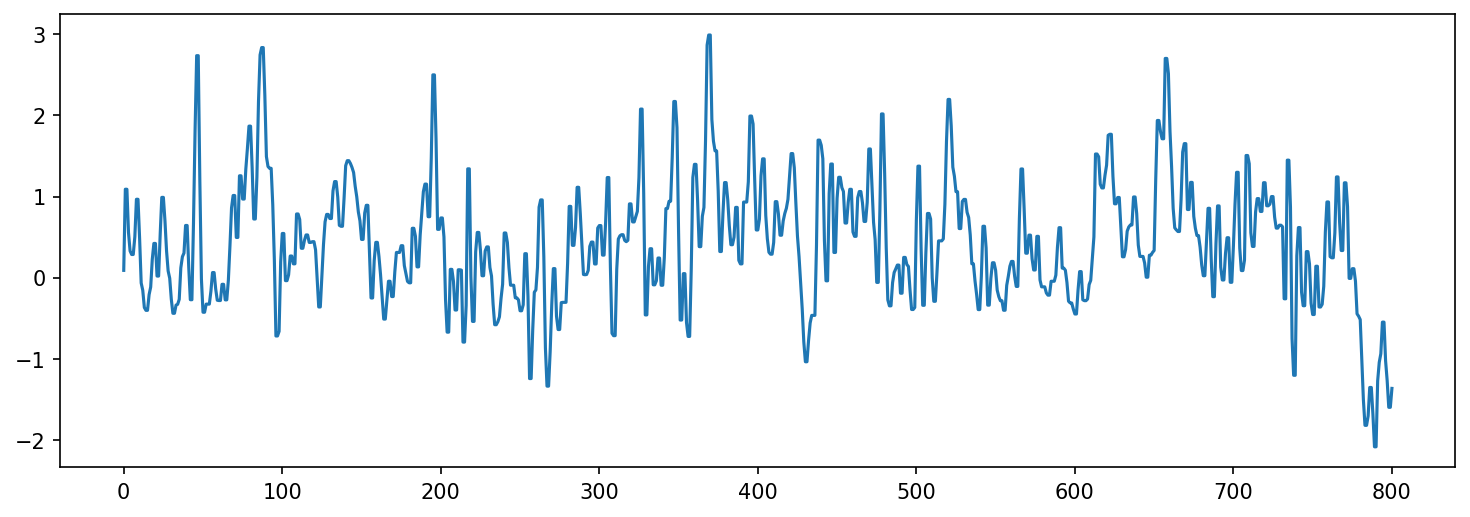

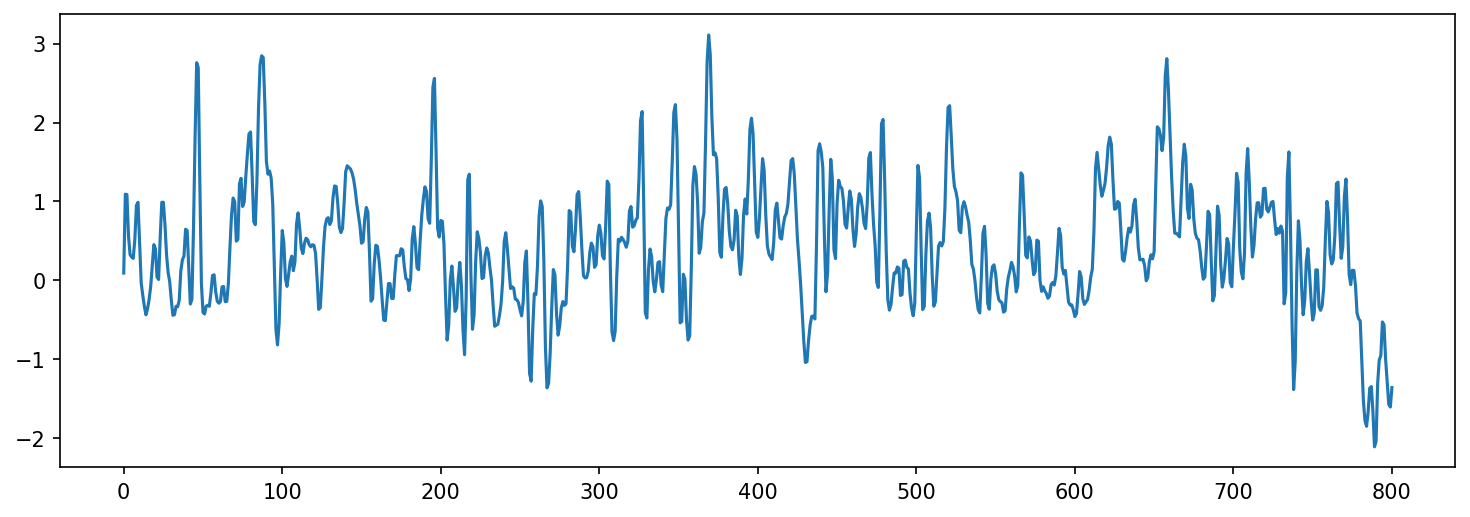

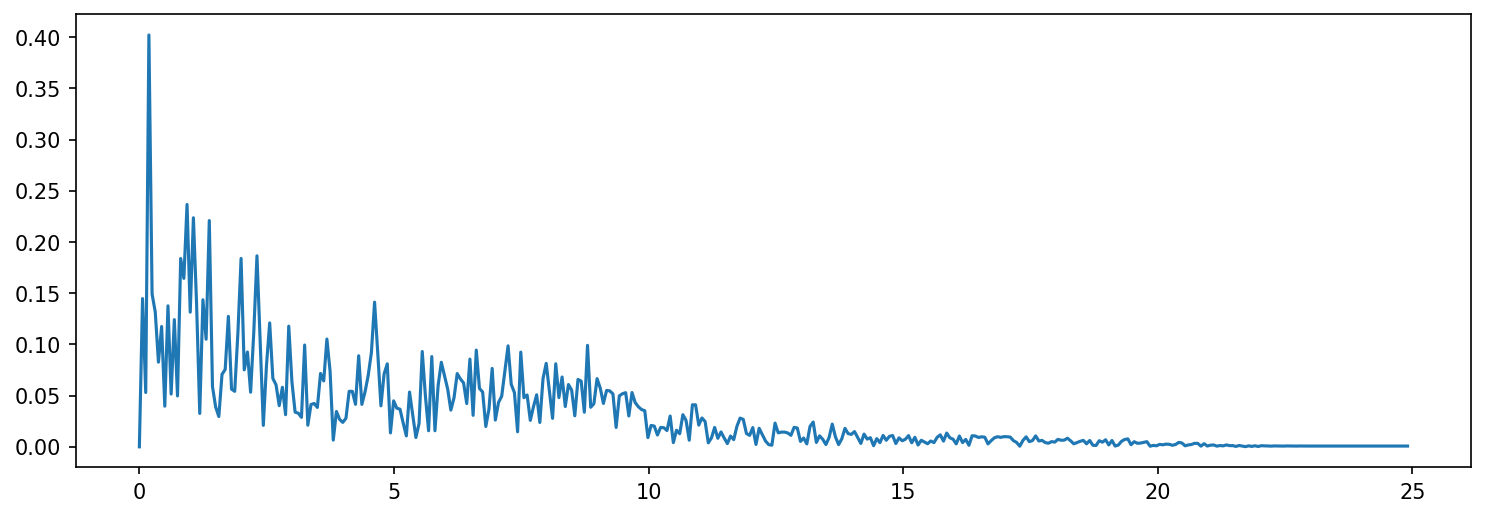

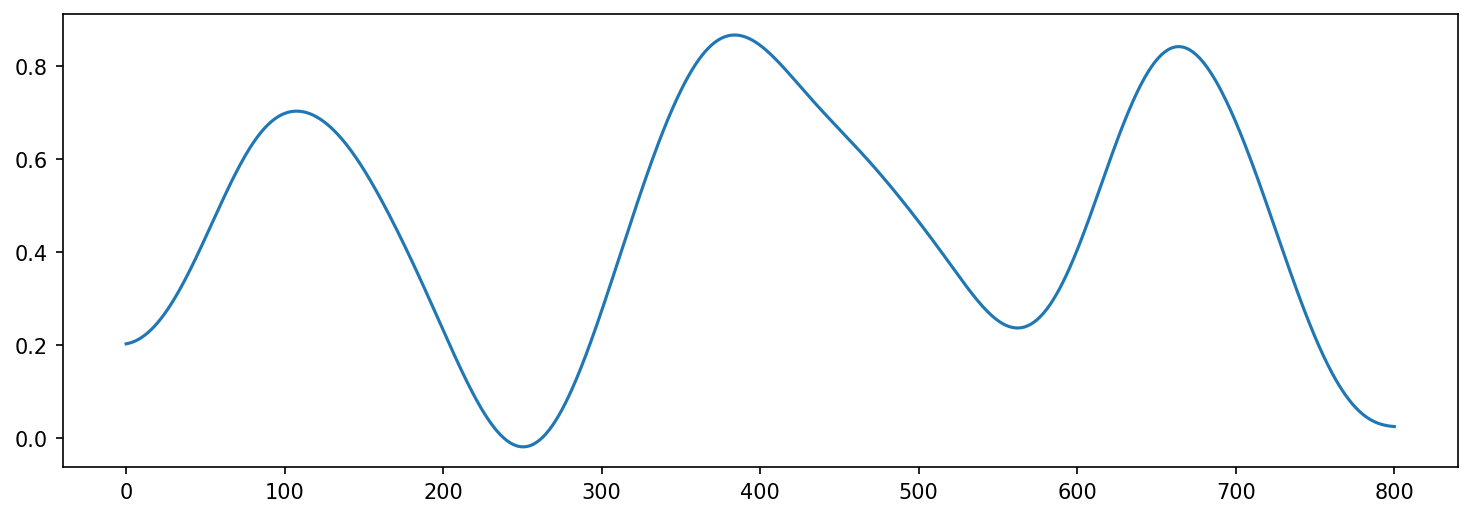

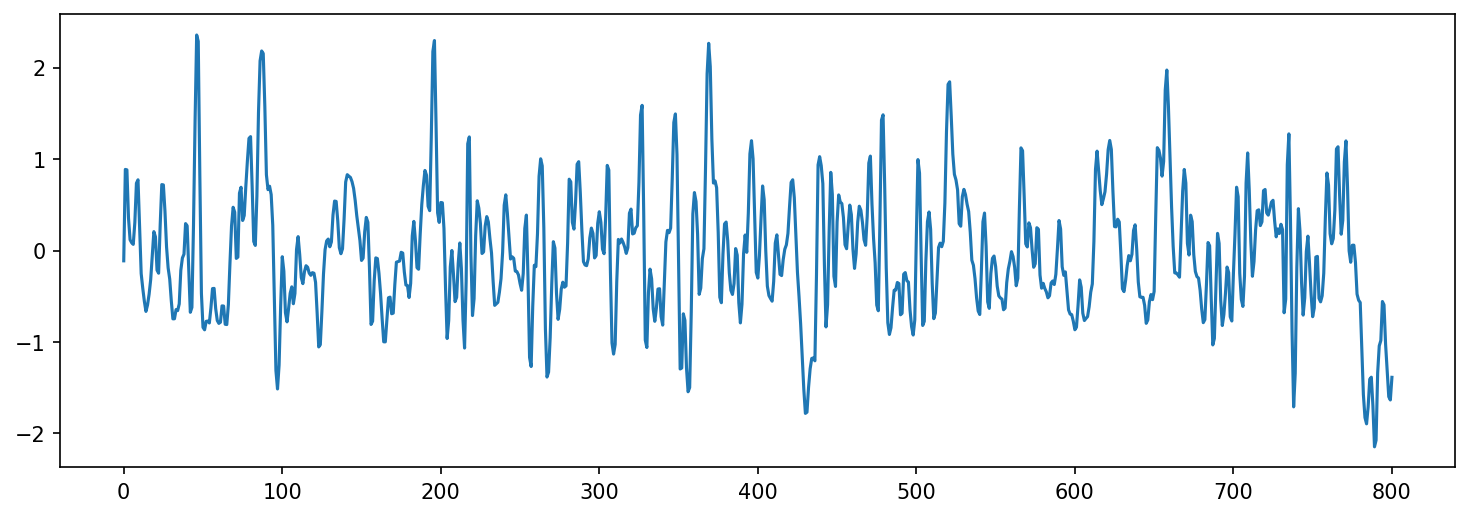

In [21]:
acc0 = file_loader(
    'C:/Users/Joker/Desktop/SURF/Dataset/Walking Upstairs/Acc/Acc0.txt')[:, 0]
print(acc0.shape)

fig1, ax1 = plt.subplots(figsize=(12, 4), dpi=150)
ax1.plot(acc0)
acc0 = signal.medfilt(acc0, 3)

fig2, ax2 = plt.subplots(figsize=(12, 4), dpi=150)
ax2.plot(acc0)

b, a = signal.butter(3, 20, 'lowpass', fs=50)
acc0 = signal.filtfilt(b, a, acc0)
# print(acc0)
fig3, ax3 = plt.subplots(figsize=(12, 4), dpi=150)
ax3.plot(acc0)

acc0f = np.abs(fft(acc0))

print(type(acc0f))
frequency = fftfreq(acc0.size, 1/50)[:int(acc0.size/2)]
normalization_acc0f = acc0f / (acc0.size / 2)  # 归一化处理（双边频谱）
normalization_acc0f[0] = 0
fig4, ax4 = plt.subplots(figsize=(12, 4), dpi=150)
ax4.plot(frequency, normalization_acc0f[0:int(acc0.size/2)])

b2, a2 = signal.butter(3, 0.3, 'lowpass', fs=50)
g = signal.filtfilt(b2, a2, acc0)
body = acc0 - g
fig5, ax5 = plt.subplots(figsize=(12, 4), dpi=150)
ax5.plot(g)
fig6, ax6 = plt.subplots(figsize=(12, 4), dpi=150)
ax6.plot(body)

In [22]:
def acc_filter(acc):
    b1, a1 = signal.butter(3, 20, 'lowpass', fs=50)
    b2, a2 = signal.butter(3, 0.3, 'lowpass', fs=50)
    acc = signal.medfilt(acc, 3)
    acc = signal.filtfilt(b1, a1, acc)
    g = signal.filtfilt(b2, a2, acc)
    body = acc - g
    return g, body

In [23]:
def gyr_filter(gyr):
    b1, a1 = signal.butter(3, 20, 'lowpass', fs=50)
    gyr = signal.medfilt(gyr, 3)
    gyr = signal.filtfilt(b1, a1, gyr)
    return gyr

In [24]:
def dataset_loader(path, type1):
    if type1 == 'Acc':
        for root, dirs, files in os.walk(path+type1+'\\'):
            # print(files)
            for name in files:
                df = file_loader(path+type1+'\\'+name)
                # print(df.shape)
                x = df[:, 0]
                x_g, x_body = acc_filter(x)
                pd.DataFrame(x_g).to_csv(
                    path+'Processed Gravity '+type1+'\\'+'x'+name, header=None, index=None)
                pd.DataFrame(x_body).to_csv(
                    path+'Processed Body '+type1+'\\'+'x'+name, header=None, index=None)
                y = df[:, 1]
                y_g, y_body = acc_filter(y)
                pd.DataFrame(y_g).to_csv(
                    path+'Processed Gravity '+type1+'\\'+'y'+name, header=None, index=None)
                pd.DataFrame(y_body).to_csv(
                    path+'Processed Body '+type1+'\\'+'y'+name, header=None, index=None)
                z = df[:, 2]
                z_g, z_body = acc_filter(z)
                pd.DataFrame(z_g).to_csv(
                    path+'Processed Gravity '+type1+'\\'+'z'+name, header=None, index=None)
                pd.DataFrame(z_body).to_csv(
                    path+'Processed Body '+type1+'\\'+'z'+name, header=None, index=None)
    elif type1 == 'Gyr':
        for root, dirs, files in os.walk(path+type1+'\\'):
            # print(files)
            for name in files:
                df = file_loader(path+type1+'\\'+name)
                # print(df.shape)
                x = df[:, 0]
                x = pd.DataFrame(gyr_filter(x))
                x.to_csv(
                    path+'Processed '+type1+'\\'+'x'+name, header=None, index=None)
                y = df[:, 1]
                y = pd.DataFrame(gyr_filter(y))
                y.to_csv(
                    path+'Processed '+type1+'\\'+'y'+name, header=None, index=None)
                z = df[:, 2]
                z = pd.DataFrame(gyr_filter(z))
                z.to_csv(
                    path+'Processed '+type1+'\\'+'z'+name, header=None, index=None)

In [25]:
walking_upstairs_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Walking Upstairs\\'
cycling_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Cycling\\'
jumping_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Jumping\\'
running_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Running\\'
sitting_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Sitting\\'
walking_downstair_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Walking Downstairs\\'
walking_path = 'C:\\Users\\Joker\\Desktop\\SURF\\Dataset\\Walking\\'
dataset_loader(walking_upstairs_path, 'Acc')
dataset_loader(walking_upstairs_path, 'Gyr')
dataset_loader(cycling_path, 'Acc')
dataset_loader(cycling_path, 'Gyr')
dataset_loader(jumping_path, 'Acc')
dataset_loader(jumping_path, 'Gyr')
dataset_loader(running_path, 'Acc')
dataset_loader(running_path, 'Gyr')
dataset_loader(sitting_path, 'Acc')
dataset_loader(sitting_path, 'Gyr')
dataset_loader(walking_path, 'Acc')
dataset_loader(walking_path, 'Gyr')
dataset_loader(walking_downstair_path, 'Acc')
dataset_loader(walking_downstair_path, 'Gyr')

去异常值 加窗

In [ ]:
# Creater: camelot
# Time: 2022/9/29 14:02
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

df = pd.read_csv('./pre_pro_data/Walking Downstairs/gra_zAcc.txt', sep=',', header=0)
d = df.values
# 归一化
min_max_x = MinMaxScaler()
d1 = min_max_x.fit_transform(d)
data = pd.DataFrame(d1)

# 去异常值
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = 1.5 * (q3 - q1)
mi = q1 - iqr
ma = q3 + iqr
print('下限为：', mi)
print('上限为：', ma)
outlier = data[(data < mi) | (data > ma)]
normal_val = data[(data > mi) & (data < ma)]

# 删除正常值中的空行
normal_val = normal_val.dropna(how="all")

# 加窗
data_pro = normal_val.values
slide_d = np.lib.stride_tricks.sliding_window_view(data_pro, 128, axis=0)
slide_d1 = slide_d[::64,]
normal_val = slide_d1[:,0,:]

# 输出为csv文件
normal_val = pd.DataFrame(normal_val)
path = './finish_data/Walking Downstairs/gra_zAcc_final.csv'
normal_val.to_csv(path, sep=',', index=False, header=True)

功率谱定义：功率谱是原信号傅立叶变换的平方并除以采样点数N，称功率谱密度函数，定义为单位频带内的信号功率，表示了信号功率随着频率的变化情况。
维纳-辛钦定理：一个信号的功率谱密度就是该信号自相关函数的傅里叶变换。

偏度  
平均频率  
峰度  
能带  

In [26]:
def get_fft_power_spectrum(y_values):
    N = y_values.size
    fft_values_ = np.abs(fft(y_values))
    fft_values = 2.0/N * (fft_values_[0:N/2])
    fft_values[0] = 0
    freq = fftfreq(N, 1/50)[:N/2]
    # 频率真实幅值分布，单边频谱图，再把所有点频率大小表示出来*2

    # power spectrum 直接周期法
    ps_values = fft_values**2 / N

    return freq, fft_values, ps_values